# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7a679c81f6714c4909350635065da17733cc21dc71ccd4f1a1bb41b7ea801c89
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a580736bfa98ea345fed8d1549f8c95fd9954dd41501a8f5d14df9dbe8ce4c40
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [1]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (3/3), done.


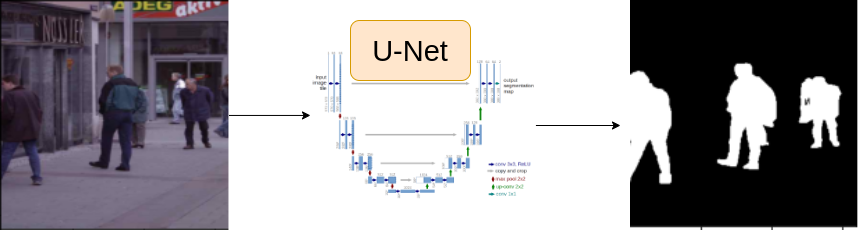

# Some Common Imports

In [2]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [4]:
Csv_file="/content/Human-Segmentation-Dataset-master/train.csv"
dir='/content/'

Device=torch.device('cpu')

epochs=25
learning_rate=0.003
Image_size=320
batch_size=16

encoder='timm-efficientnet-b0'
weights='imagenet'

In [5]:
df=pd.read_csv(Csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[1]

image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=image=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/ 255.0



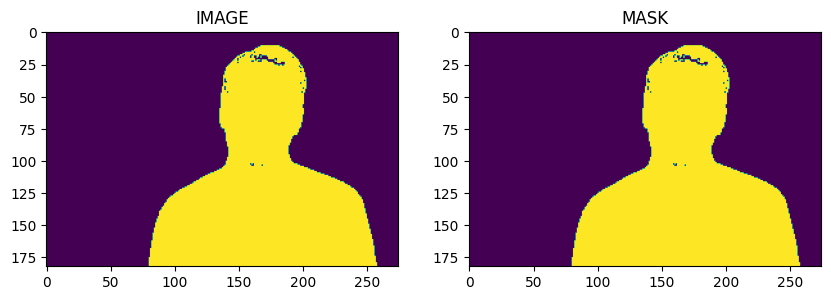

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(Image_size,Image_size),
      A.HorizontalFlip(p=1),
      A.VerticalFlip(p=1),
    ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(Image_size,Image_size),
  ],is_check_shapes=False)



# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset


In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    image=np.transpose(image,(2,0,1)).astype(np.float32)
     #(h0,w1,c2)-->(c2,h0,w1)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image) / 255.0

    mask=torch.round(torch.Tensor(mask)/ 255.0)

    return image,mask






In [ ]:
# Assuming the SegmentationDataset class has the following constructor:
# SegmentationDataset(dataframe, augmentations)

trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


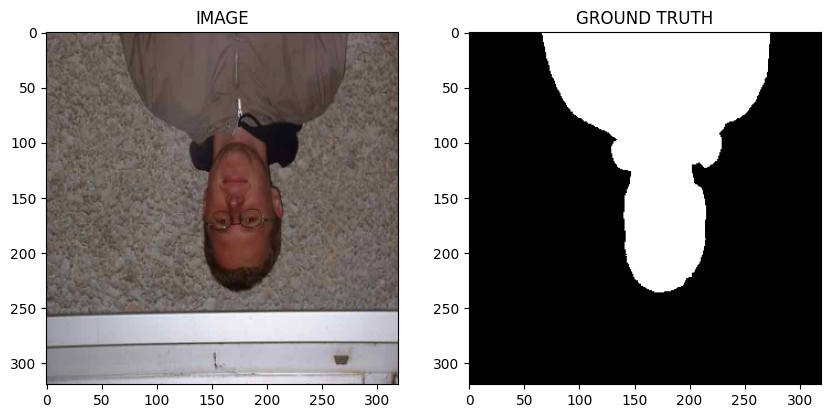

In [ ]:
idx=31

image,mask =trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader


In [ ]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader=DataLoader(validset,batch_size=batch_size)

In [ ]:
print(f'total no of batches in trainloader:{len (trainloader)}')
print(f'total no of batches in validloader:{len (validloader)}')

total no of batches in trainloader:15
total no of batches in validloader:4


In [ ]:
for image, mask in trainloader :
  break


print(f"one batch image shape:{image.shape}")
print(f"one batch mask shape : {mask.shape}")

one batch image shape:torch.Size([16, 3, 320, 320])
one batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss



In [ ]:
class segmentation_Model(nn.Module):

  def __init__(self):
    super(segmentation_Model , self).__init__()

    self.arc=smp.Unet(
      encoder_name=encoder,
      encoder_weights=weights,
      in_channels=3,
      classes=1,
      activation=None
  )

  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks != None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1,loss2

    return logits



In [ ]:
model=segmentation_Model().to(Device)
model.to(Device);

# Task 7 : Create Train and Validation Function

In [ ]:
# def train_fn(data_loader,model,optimizer):
#   model.train()
#   total_loss=0.0

#   for images,masks in tqdm(data_loader):
#     images=images.to(Device)
#     masks=masks.to(Device)

#     optimizer.zero_grad()

#     outputs = model(images)


#     if 'logits' in outputs and 'loss' in outputs:
#             logits, loss = outputs['logits'], outputs['loss']


#     loss.backword()
#     optimizer.step()

#     total_loss += loss.item()
# else:
#     raise RuntimeError("Expected 'logits' and 'loss' in model outputs.")

# return total_loss / len(data_loader)


In [ ]:
# def train_fn(data_loader, model, optimizer):
#     model.train()
#     total_loss = 0.0

#     for images, masks in tqdm(data_loader):
#         images = images.to(Device)
#         masks = masks.to(Device)

#         optimizer.zero_grad()

#         outputs = model(images)
#         logits, loss = outputs['logits'], outputs['loss']

#             # Perform backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     return total_loss / len(data_loader)


In [ ]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images=images.to(Device)
      masks=masks.to(Device)

      logits,loss=model(images,masks)
      loss.backword()

      total_loss+=loss.item()

  return total_loss/len(data_loader)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Task 8 : Train Model

In [ ]:
optimizer= torch.optim.Adam(model.parameters() , lr=learning_rate)


In [ ]:
best_valid_loss=np.Inf

for i in range(epochs):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss=valid_loss


  print(f"epochs:{i+1} Train_loss:{train_loss} Valid_loss:{valid_loss}")


  0%|          | 0/15 [00:15<?, ?it/s]

Shape of outputs tensor: torch.Size([16, 1, 320, 320])


AttributeError: 'Tensor' object has no attribute 'keys'

# Task 9 : Inference

In [ ]:
idx=20


model.load_state_dict(torch.load("")) #best model link

image,mask=validset[idx]

logits_mask=model(image.to(Device).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0


In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya